### Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [ ]:
%load_ext nb_black

### Import Dataset

<b> Dataset Link (Plant Vliiage Dataset ):</b><br> <a href='https://data.mendeley.com/datasets/tywbtsjrjv/1'> https://data.mendeley.com/datasets/tywbtsjrjv/1 </a> 

In [3]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

In [4]:
dataset = datasets.ImageFolder("Dataset", transform=transform)

In [5]:
dataset

Dataset ImageFolder
    Number of datapoints: 61486
    Root Location: Dataset
    Transforms (if any): Compose(
                             Resize(size=255, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                         )
    Target Transforms (if any): None

In [6]:
indices = list(range(len(dataset)))

In [7]:
split = int(np.floor(0.85 * len(dataset)))  # train_size

In [8]:
validation = int(np.floor(0.70 * split))  # validation

In [9]:
print(0, validation, split, len(dataset))

0 36584 52263 61486


In [10]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :36584
length of validation size :15679
length of test size :24902


In [11]:
np.random.shuffle(indices)

### Split into Train and Test

In [12]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [13]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [15]:
targets_size = len(dataset.class_to_idx)
targets_size

39

### Model

<b>Convolution Aithmetic Equation : </b>(W - F + 2P) / S + 1 <br>
W = Input Size<br>
F = Filter Size<br>
P = Padding Size<br>
S = Stride <br>

### Transfer Learning

In [ ]:
# model = models.vgg16(pretrained=True)

In [ ]:
# for params in model.parameters():
#     params.requires_grad = False

In [ ]:
# model

In [ ]:
# n_features = model.classifier[0].in_features
# n_features

In [ ]:
# model.classifier = nn.Sequential(
#     nn.Linear(n_features, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(1024, targets_size),
# )

In [ ]:
# model

### Original Modeling

In [ ]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X.to('mps'))

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [16]:
device = torch.device("mps")
print(device)

mps


In [17]:
device = "mps"

In [18]:
model = CNN(targets_size)

In [19]:
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [20]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

In [21]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

### Batch Gradient Descent

In [22]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        print('Train Loader')
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []
        print('Validation Loader')
        for inputs, targets in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [23]:
device = "mps"

In [24]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [25]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 5
)

Train Loader
Validation Loader
Epoch : 1/5 Train_loss:inf Test_loss:1.477 Duration:0:16:22.998552
Train Loader
Validation Loader
Epoch : 2/5 Train_loss:1.235 Test_loss:1.081 Duration:0:24:27.997046
Train Loader
Validation Loader
Epoch : 3/5 Train_loss:inf Test_loss:0.963 Duration:0:18:21.197068
Train Loader
Validation Loader
Epoch : 4/5 Train_loss:0.797 Test_loss:0.907 Duration:0:22:52.418505
Train Loader
Validation Loader
Epoch : 5/5 Train_loss:0.651 Test_loss:0.703 Duration:0:25:52.547236


### Save the Model

In [26]:
#torch.save(model.state_dict() , 'plant_disease_model_1.pt')

### Load Model

In [ ]:
targets_size = 39
model = CNN(targets_size)
model.load_state_dict(torch.load("plant_disease_model_1_latest.pt"))
model.eval()
model.to(device)

In [ ]:
# %matplotlib notebook

### Plot the loss

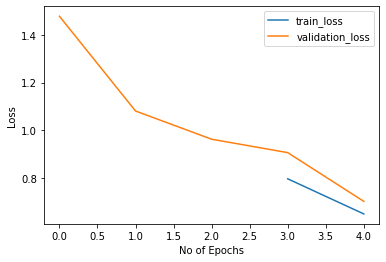

In [102]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

In [103]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        print(outputs)
        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [104]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

/Users/mayanksharma/miniforge3/envs/tf_env/lib/python3.8/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525682339/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


tensor([[-11.9380,  -9.0976, -15.9917,  ...,   6.4346,  -4.0076,  -7.2355],
        [ -2.7270, -13.2197,  -3.6434,  ..., -18.1178, -25.4094,  -6.3304],
        [ 14.8179,  21.3840, -25.1555,  ..., -24.6131,  11.4732, -19.8156],
        ...,
        [  0.1514, -25.3484,  -6.9200,  ...,  -0.4023,  -7.6009,  24.1111],
        [  9.7579,  -2.3692, -11.2275,  ...,  -9.5885,   0.9495,  -1.0200],
        [ -7.3123,  -9.8968, -18.2220,  ...,  -3.2401,   2.1989,   8.5666]],
       device='mps:0', grad_fn=<LinearBackward0>)
tensor([[-10.4173,  -6.1988,   0.0433,  ...,  -1.3619, -14.6330, -18.4624],
        [  4.4843,  -0.1618, -16.5299,  ...,  -5.9427,  -0.3697,  -4.3338],
        [ -3.8659, -18.7977,  -0.8319,  ..., -12.1064, -11.8018,   2.4768],
        ...,
        [ -7.0109, -10.4547,  -2.4423,  ...,  -5.7545, -17.2350, -19.5651],
        [ -2.3837, -11.3642,   1.0944,  ...,  -0.3505, -11.3899,  -4.4099],
        [ -5.2813,  -8.3448, -16.1597,  ..., -17.7549, -22.6550, -23.4072]],
       dev

In [105]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.9200470150885633
Test Accuracy : 0.8919006830749214
Validation Accuracy : 0.8890873142419797


### Single Image Prediction

In [106]:
transform_index_to_disease = dataset.class_to_idx

In [107]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)  # reverse the index

In [108]:
data = pd.read_csv("disease_info.csv", encoding="cp1252")

In [109]:
from PIL import Image
import os
import torchvision.transforms.functional as TF

In [112]:
def single_prediction(image_path):
    path = os.path.join(os.getcwd(),'..')
    image = Image.open(path+'/'+image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data).cpu()
    output = output.detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[12:-4])
    pred_csv = data["disease_name"][index]
    print(pred_csv)

In [113]:
single_prediction("test_images/Apple_ceder_apple_rust.JPG")

Original :  Apple_ceder_apple_rust
Apple : Cedar rust


### Wrong Prediction

In [114]:
single_prediction("test_images/Apple_scab.JPG")

Original :  Apple_scab
Apple : Black Rot


In [115]:
single_prediction("test_images/Grape_esca.JPG")

Original :  Grape_esca
Grape : Esca | Black Measles


In [116]:
single_prediction("test_images/apple_black_rot.JPG")

Original :  apple_black_rot
Cherry : Healthy


In [117]:
single_prediction("test_images/apple_healthy.JPG")

Original :  apple_healthy
Apple : Healthy


In [118]:
single_prediction("test_images/background_without_leaves.jpg")

Original :  background_without_leaves
Background Without Leaves


In [119]:
single_prediction("test_images/blueberry_healthy.JPG")

Original :  blueberry_healthy
Blueberry : Healthy


In [120]:
single_prediction("test_images/cherry_healthy.JPG")

Original :  cherry_healthy
Cherry : Healthy


In [121]:
single_prediction("test_images/cherry_powdery_mildew.JPG")

Original :  cherry_powdery_mildew
Apple : Cedar rust


In [122]:
single_prediction("test_images/corn_cercospora_leaf.JPG")

Original :  corn_cercospora_leaf
Corn : Cercospora Leaf Spot | Gray Leaf Spot


In [123]:
single_prediction("test_images/corn_common_rust.JPG")

Original :  corn_common_rust
Corn : Common Rust


In [124]:
single_prediction("test_images/corn_healthy.jpg")

Original :  corn_healthy
Corn : Healthy


In [125]:
single_prediction("test_images/corn_northen_leaf_blight.JPG")

Original :  corn_northen_leaf_blight
Corn : Cercospora Leaf Spot | Gray Leaf Spot


In [126]:
single_prediction("test_images/grape_black_rot.JPG")

Original :  grape_black_rot
Grape : Black Rot


In [127]:
single_prediction("test_images/grape_healthy.JPG")

Original :  grape_healthy
Grape : Healthy


In [128]:
single_prediction("test_images/grape_leaf_blight.JPG")

Original :  grape_leaf_blight
Grape : Leaf Blight | Isariopsis Leaf Spot


In [129]:
single_prediction("test_images/orange_haunglongbing.JPG")

Original :  orange_haunglongbing
Orange : Haunglongbing | Citrus Greening


In [130]:
single_prediction("test_images/peach_bacterial_spot.JPG")

Original :  peach_bacterial_spot
Peach : Bacterial Spot


In [131]:
single_prediction("test_images/peach_healthy.JPG")

Original :  peach_healthy
Peach : Healthy


In [132]:
single_prediction("test_images/pepper_bacterial_spot.JPG")

Original :  pepper_bacterial_spot
Pepper bell : Bacterial Spot


In [133]:
single_prediction("test_images/pepper_bell_healthy.JPG")

Original :  pepper_bell_healthy
Pepper bell : Healthy


In [134]:
single_prediction("test_images/potato_early_blight.JPG")

Original :  potato_early_blight
Potato : Early Blight


In [135]:
single_prediction("test_images/potato_healthy.JPG")

Original :  potato_healthy
Potato : Healthy


In [136]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Potato : Late Blight


In [137]:
single_prediction("test_images/raspberry_healthy.JPG")

Original :  raspberry_healthy
Raspberry : Healthy


In [138]:
single_prediction("test_images/soyaben healthy.JPG")

Original :  soyaben healthy
Potato : Healthy


In [139]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Potato : Late Blight


In [140]:
single_prediction("test_images/squash_powdery_mildew.JPG")

Original :  squash_powdery_mildew
Tomato : Healthy


In [141]:
single_prediction("test_images/starwberry_healthy.JPG")

Original :  starwberry_healthy
Strawberry : Healthy


In [142]:
single_prediction("test_images/starwberry_leaf_scorch.JPG")

Original :  starwberry_leaf_scorch
Strawberry : Leaf Scorch


In [143]:
single_prediction("test_images/tomato_bacterial_spot.JPG")

Original :  tomato_bacterial_spot
Tomato : Bacterial Spot


In [144]:
single_prediction("test_images/tomato_early_blight.JPG")

Original :  tomato_early_blight
Tomato : Early Blight


In [145]:
single_prediction("test_images/tomato_healthy.JPG")

Original :  tomato_healthy
Tomato : Healthy


In [146]:
single_prediction("test_images/tomato_late_blight.JPG")

Original :  tomato_late_blight
Tomato : Late Blight


In [147]:
single_prediction("test_images/tomato_leaf_mold.JPG")

Original :  tomato_leaf_mold
Tomato : Leaf Mold


In [148]:
single_prediction("test_images/tomato_mosaic_virus.JPG")

Original :  tomato_mosaic_virus
Tomato : Mosaic Virus


In [149]:
single_prediction("test_images/tomato_septoria_leaf_spot.JPG")

Original :  tomato_septoria_leaf_spot
Tomato : Septoria Leaf Spot


In [150]:
single_prediction("test_images/tomato_spider_mites_two_spotted_spider_mites.JPG")

Original :  tomato_spider_mites_two_spotted_spider_mites
Tomato : Spider Mites | Two-Spotted Spider Mite


In [151]:
single_prediction("test_images/tomato_target_spot.JPG")

Original :  tomato_target_spot
Tomato : Target Spot


In [152]:
single_prediction("test_images/tomato_yellow_leaf_curl_virus.JPG")

Original :  tomato_yellow_leaf_curl_virus
Tomato : Yellow Leaf Curl Virus
